In [15]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [16]:
listings = pd.read_csv('data/listings_CPH.csv')

## Prediction Challenge

### Binary Classification
We start off by having a brief look at the data.

In [17]:
listings.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
0,6983,Copenhagen 'N Livin',16774,Simon,NaN,Nrrebro,55.686410,12.547410,Entire home/apt,898,3,172,2022-06-21,1.08,1,0,4,NaN
1,26057,Lovely house - most attractive area,109777,Kari,NaN,Indre By,55.693070,12.576490,Entire home/apt,2600,4,59,2022-08-09,0.55,1,303,8,NaN
2,26473,City Centre Townhouse Sleeps 1-10 persons,112210,Julia,NaN,Indre By,55.676020,12.575400,Entire home/apt,3250,3,300,2022-09-10,2.06,3,56,7,NaN
3,29118,Best Location in Cool Istedgade,125230,Nana,NaN,Vesterbro-Kongens Enghave,55.670230,12.555040,Entire home/apt,725,7,24,2022-08-04,0.16,1,59,2,NaN
4,31094,"Beautiful, spacious, central, renovated Penthouse",129976,Ebbe,NaN,Vesterbro-Kongens Enghave,55.666602,12.555283,Entire home/apt,1954,3,19,2022-08-22,0.13,1,0,2,NaN


In [18]:
listings.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
count,1.381500e+04,1.381500e+04,0.0,13815.000000,13815.000000,13815.000000,13815.000000,13815.000000,12170.000000,13815.000000,13815.000000,13815.000000,0.0
mean,1.719385e+17,1.064145e+08,NaN,55.680569,12.557805,1205.878972,4.605574,18.571118,0.903816,4.400651,93.302642,5.451104,NaN
std,2.852538e+17,1.302801e+08,NaN,0.021088,0.033512,1433.143149,16.900153,36.402671,1.110754,21.298565,123.161958,11.373977,NaN
min,6.983000e+03,1.171800e+04,NaN,55.609510,12.435670,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000,NaN
25%,1.907962e+07,1.356383e+07,NaN,55.666110,12.540285,729.000000,2.000000,2.000000,0.230000,1.000000,0.000000,0.000000,NaN
50%,3.931542e+07,4.656301e+07,NaN,55.681190,12.555520,995.000000,3.000000,7.000000,0.530000,1.000000,20.000000,3.000000,NaN
75%,5.665348e+17,1.553486e+08,NaN,55.695770,12.580741,1368.500000,4.000000,20.000000,1.120000,1.000000,174.000000,6.000000,NaN
max,7.222925e+17,4.805803e+08,NaN,55.742800,12.651740,64900.000000,1111.000000,711.000000,24.020000,179.000000,365.000000,471.000000,NaN


In [19]:
listings.isna().sum() / listings.count()

id                                0.000000
name                              0.000000
host_id                           0.000000
host_name                         0.000072
neighbourhood_group                    inf
neighbourhood                     0.000000
latitude                          0.000000
longitude                         0.000000
room_type                         0.000000
price                             0.000000
minimum_nights                    0.000000
number_of_reviews                 0.000000
last_review                       0.135168
reviews_per_month                 0.135168
calculated_host_listings_count    0.000000
availability_365                  0.000000
number_of_reviews_ltm             0.000000
license                                inf
dtype: float64

We immediately notice that `neighbourhood_group` and `license` are missing all values. We will therefore drop these columns.

We'll assume that `id`, `name`, `host_id`, `host_name` and `neighbourhood_group` are irrelevant to our analysis, and therefore drop these columns as well.

We also notice that `last_review` and `reviews_per_month` have the same percentage of missing values. This is because listings with no reviews can't have a value for `last_review` or `reviews_per_month`. We will impute these values with -1.

In [20]:
listings = listings.drop(["id", "name", "host_id", "host_name", "neighbourhood_group", "license", "last_review"], axis=1)
listings[["reviews_per_month"]] = listings[["reviews_per_month"]].fillna(-1)

To deal with categorical features such as `neighbourhood` and `room_type` we will use one-hot encoding.

In [21]:
listings = pd.get_dummies(listings, columns=["neighbourhood", "room_type"])

We will now split the data into a training and test set. The target will be created from the splits such as to avoid data leakage. The targets are created as being higher or lower than the median price. Median price is chosen as the target because it is less sensitive to outliers than the mean price, meaning that the mean price will not necessarily be a good measure of central tendency in "high" and "low" prices.

In [22]:
# split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(listings)
X_train, y_train = train.drop("price", axis=1), (train["price"] > train["price"].median()).astype(int)
X_test, y_test = test.drop("price", axis=1), (test["price"] > test["price"].median()).astype(int)

#### Predictions, error analysis and interpretation

Accuracy score: 0.677475390851187
F1-Score: 0.685843203609701


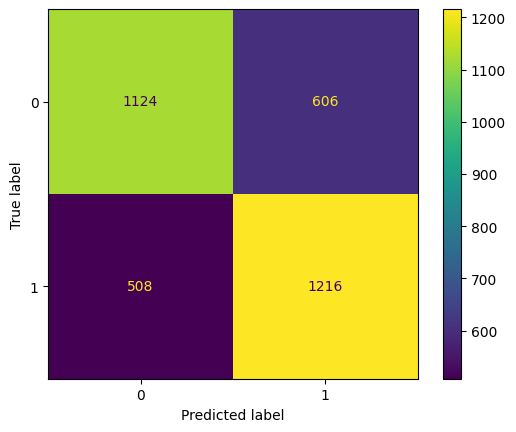

In [23]:
# train logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# evaluate model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred)}")

We obtain both an accuracy and F1-Score **above 0.6** with a default logistic regression classifier. From the confusion matrix we see that the classifier is slightly more prone to false positives than it is false negatives. 

In [24]:
y_pred = model.predict(X_train)
print(f"Accuracy score: {accuracy_score(y_train, y_pred)}")
print(f"F1-Score: {f1_score(y_train, y_pred)}")

Accuracy score: 0.6628703793070166
F1-Score: 0.6687529634898056


To assess overfitting we see that the predicting on the training set performs approximately equally well, indicating that it hasn't overfitted to the training set.

One of the strengths of the logistic regression method is the interpretability that the coefficients provide. Let's have a look at those.

In [25]:
coefficients = pd.DataFrame({"feature": X_train.columns, "coefficient": model.coef_[0]})
coefficients.sort_values("coefficient", ascending=False)

,feature,coefficient
19,room_type_Entire home/apt,1.347013
13,neighbourhood_Indre By,1.296799
8,neighbourhood_Amager Vest,0.338543
12,neighbourhood_Frederiksberg,0.332253
17,neighbourhood_Vesterbro-Kongens Enghave,0.320123
1,longitude,0.159953
18,neighbourhood_sterbro,0.107266
5,calculated_host_listings_count,0.005405
6,availability_365,0.003690
7,number_of_reviews_ltm,0.002915


This would indicate that a listing's price is heavily influenced by its type as well as location which is to be expected. The feature `calculated_host_listings_count` also indicates an influence towards higher prices. This is likely due to the fact that hosts with more listings are more likely to be professional hosts, and therefore have higher prices.

### Multiclass Classification

We create the labels such that the price is divided into 3 categories: "Low" (which is to be less than the .33th quantile), "Medium" (which is to be inbetween the 0.33th and 0.66th quantile) and "High" (which is to be larger than the 0.66th quantile). 

As with the binary classification, we split the data first and create labels from the splits' quantiles in order to avoid leakage.

In [26]:
train, test = train_test_split(listings)

def create_targets(prices):
    labels = []
    for price in prices:
        if price < prices.quantile(0.33):
            labels.append("Low")
        if prices.quantile(0.33) <= price <= prices.quantile(0.66):
            labels.append("Medium")
        if price > prices.quantile(0.66):
            labels.append("High")
    return labels

y_train, y_test = create_targets(train["price"]), create_targets(test["price"])
X_train, X_test = train.drop("price", axis=1), test.drop("price", axis=1)

In [27]:
def create_target(prices):
    labels = []
    for price in prices:
        if price < prices.quantile(0.33):
            labels.append("Low")
        if prices.quantile(0.33) <= price <= prices.quantile(0.66):
            labels.append("Medium")
        elif price > prices.quantile(0.66):
            labels.append("High")
    return labels

#### Predictions, error analysis and interpretation

Accuracy score: 0.515055008685582
F1-Score: 0.5039081616703698


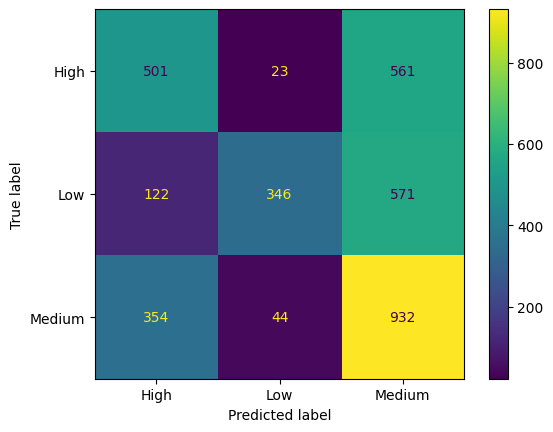

In [28]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
plot_confusion_matrix(model, X_test, y_test)
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")
print(f"F1-Score: {f1_score(y_test, y_pred, average='macro')}")

For the multiclass classification we also use a default logistic regression. We obtain an accuracy and F1-Score of about **0.5**. This is an improvement over random guessing, which would be 1/3. From the confusion matrix we see that the classifier is very prone to predicting things as being medium priced.

We again compare to the accuracy and F1-Score on the predictions on the training set and see that it performs approximately equally well, indicating that it hasn't overfitted to the training set.

In [29]:
y_pred = model.predict(X_train)
print(f"Accuracy score: {accuracy_score(y_train, y_pred)}")
print(f"F1-Score: {f1_score(y_train, y_pred, average='macro')}")

Accuracy score: 0.5179036772512305
F1-Score: 0.5054696476064168


<AxesSubplot:ylabel='feature'>

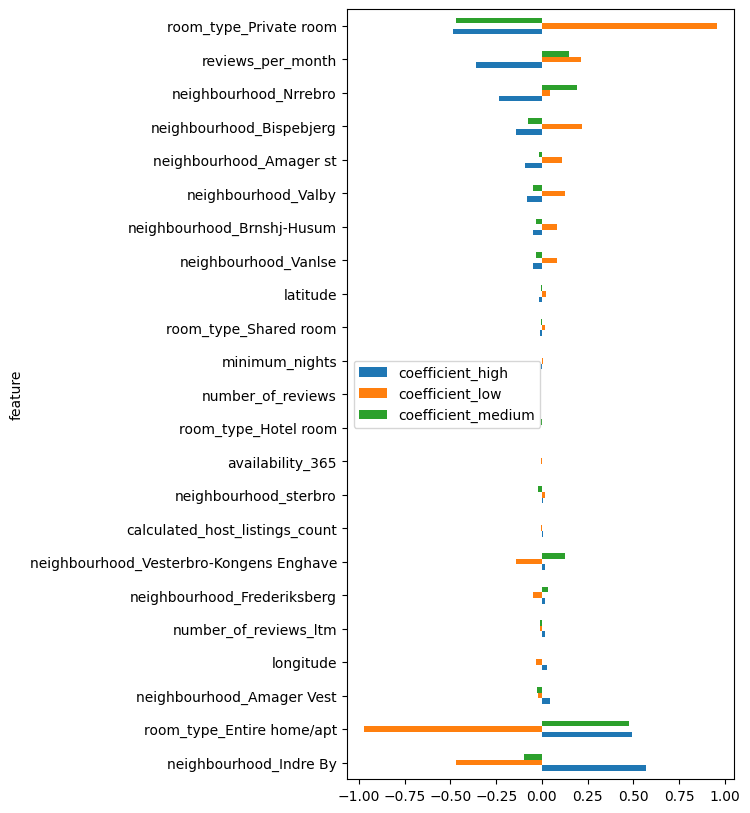

In [32]:
# interpret coefficients
coefficients = pd.DataFrame({"feature": X_train.columns, 
                             "coefficient_high": model.coef_[0],
                             "coefficient_low": model.coef_[1], 
                             "coefficient_medium": model.coef_[2]})
coefficients.sort_values("coefficient_high", ascending=False).set_index("feature").plot(kind="barh", figsize=(5, 10))

From these coefficients we get a clear overview of how the price is influenced by different features. Things such as Home/Apt room type is strongly disassociated with a lower price while a neighbourhood such as Indre By is strongly associated with a higher price.

We also see that the Medium labeled listings share a lot of feature weights with both High and Low, explaining why the classifier has a hard time and predicts Medium falsely a lot.